**Initialization**

In [1]:
import numpy as np

import datetime as dt

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

# **Task 1: Data set**

The Cifar10 dataset comes directly in a two-part dataset for training and test data. The training dataset contains 50000 image-label pairs and the test dataset 10000 image-label pairs. The labels are displayed as numbers from 0 to 9. Among other things in the following code snippet these numbers are mapped to their string label class names. The images in the datasets come up with a fixed shape of 32 x 32 x 3. Thus no resizing is necessary. 

Additionally, some example images of the dataset are displayed with the corresponding string label class name.

170500096/170498071 [==============================] - 11s 0us/step
Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


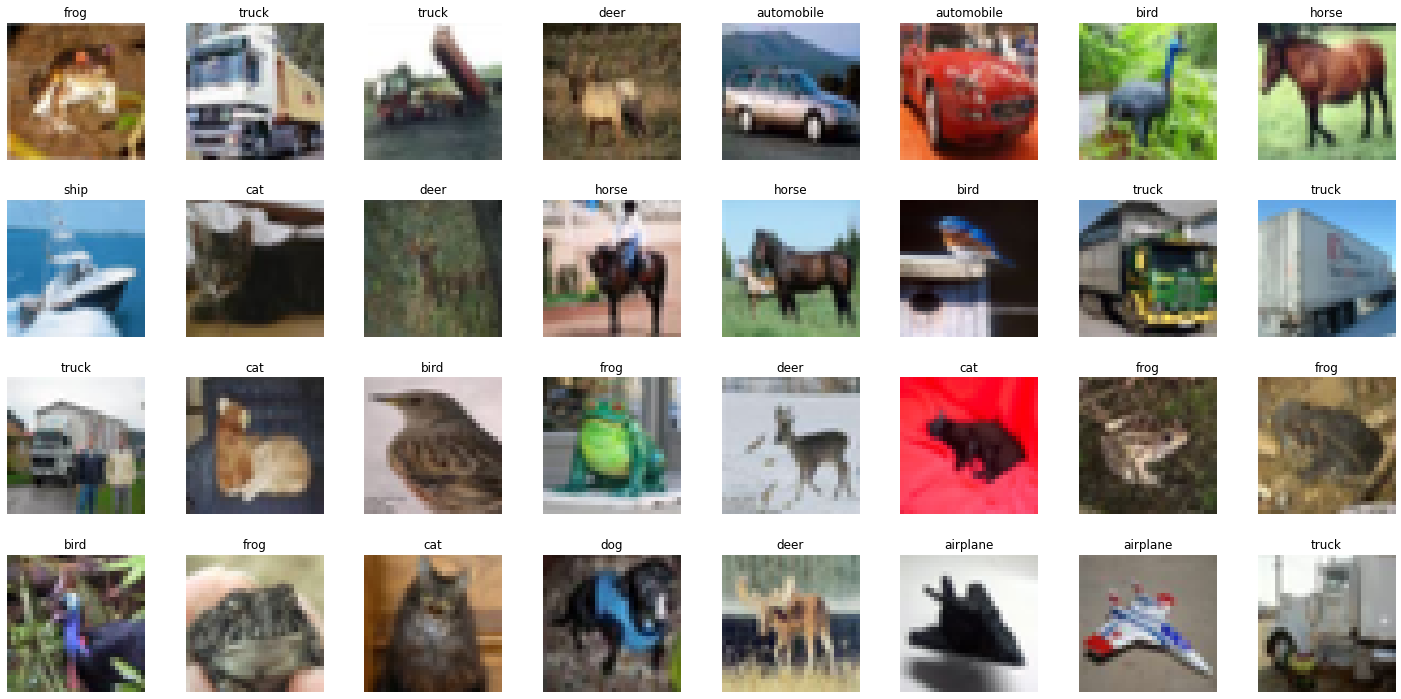

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline

In [3]:
batch_size = 128

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

# **Task 2.2: Model - DenseNet**

**Class TransitionLayer**

Implementation of a callable Transition Layer for the DenseNet. 

This one should include:

*   Concolutional Layer
*   Batch Normalization
*   Activation Function ReLu
*   Pooling Layer (AveragePooling)













In [4]:
# Description: The class TransitionLayer describes a transition layer of a DenseNet.
class TransitionLayer(tf.keras.layers.Layer): 
  
  def __init__(self, num_channels_trans_layer):
    super(TransitionLayer, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = num_channels_trans_layer,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
    self.activ_1 = tf.keras.activations.relu
    self.dropout = tf.keras.layers.GaussianDropout(rate = 0.5)                       
    self.aver_pool_1 = tf.keras.layers.AveragePooling2D(strides=(2, 2), padding = 'same')   #Without strides?

  # Description: This function conducts one forward-step of the transition layer. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.aver_pool_1(x)
    return x

**Class ConvolutionalBlock**

This class is needed to create a Dense Block. It includes one convolutional layer. When calling, the forward step is conducted and the output of the layer is concatenate with the input itself. The result of the concatenation is the output of the convolutional block.

In [5]:
# Description: The class ConvolutionalBlock describes a convolutional block of a DenseBlock.
class ConvolutionalBlock(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(ConvolutionalBlock, self).__init__()

    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu                
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.conv_2 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_2 = tf.keras.activations.relu          
    self.concat = tf.keras.layers.Concatenate()               

  # Description: This function conducts one forward-step of the convolutional block. Therefore the block output
  #              is concatenated with the block input. The python decorator @tf.function is used to bundle multiple 
  #              computations into one computational graph.
  #              @parameters: block_input, training (to differ between training and test calls of the residual block)
  #              @returns: block_output
  @tf.function
  def call(self, block_input, training = True):
    x = self.batch_norm_1(block_input, training)
    x = self.activ_1(x)
    x = self.conv_1(x)
    x = self.conv_2(x) 
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)

    block_output = self.concat([x, block_input]) 
    return block_output

**Class DenseBlock**

Implementation of the Dense Blocks for the DenseNet. They include as many convolutional blocks as the init parameter num_conv_blocks defines. The total number of convolutional layers of the Dense Block is num_conv_blocks.

In [6]:
# Description: The class DenseBlock describes a dense block of a DenseNet.
class DenseBlock(tf.keras.layers.Layer): 

  def __init__(self, num_conv_blocks):
    super(DenseBlock, self).__init__()

    self.convolutional_blocks = []
    for _ in range(num_conv_blocks):
      self.convolutional_blocks.append(ConvolutionalBlock())

  # Description: This function conducts one forward-step of the dense block. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (output) x
  @tf.function
  def call(self, x, training = True):
    for conv_block in self.convolutional_blocks:
      x = conv_block(x, training)
    return x

**Class DenseNet**

In [7]:
# The class DenseNet describes a dense convolutional neural network with a feature extractor and a classifier.
class DenseNet(tf.keras.Model): 
  
  def __init__(self, num_dense_blocks, num_conv_blocks, growth_rate):
    super(DenseNet, self).__init__()

    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (32, 32, 3))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu   
    self.dropout_1 = tf.keras.layers.GaussianDropout(rate = 0.5)   

    num_channels_trans_layer = growth_rate * num_conv_blocks
    self.dense_blocks_and_trans_layers = []
    for _ in range(num_dense_blocks - 1):                         # The last dense block does not need a transition layer -> num_dense_blocks - 1 
      self.dense_blocks_and_trans_layers.append(DenseBlock(num_conv_blocks))   
      self.dense_blocks_and_trans_layers.append(TransitionLayer(num_channels_trans_layer)) 
    self.last_dense_block = DenseBlock(num_conv_blocks)

    # Classifier
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout_2 = tf.keras.layers.GaussianDropout(rate = 0.5)                                               # (5)    
    self.output_layer = tf.keras.layers.Dense(10, 
                                              activation=tf.keras.activations.softmax)#,
                                              #kernel_initializer = tf.keras.initializers.glorot_normal,   
                                              #bias_initializer = 'zeros',                                 
                                              #kernel_regularizer = tf.keras.regularizers.L2(0.01))

  # Description: This function conducts one forward-step of the Dense CNN. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.dropout_1(x, training)

    for i in self.dense_blocks_and_trans_layers:
      x = i(x, training)
    x = self.last_dense_block(x, training)

    x = self.global_pool(x)
    x = self.dropout_2(x)
    x = self.output_layer(x)
    return x

# **Task 3: Training and Analysis**

In [8]:
# Description: This function conducts a forward-step and the backpropagation of a CNN. It does not matter whether the CNN is a ResNet or 
#              a DenseNet (this is defined by the parameter model). Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training (to differ between training and test calls of the CNN)
#              @returns: training_loss, training_accuracy
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction)+ tf.math.reduce_sum(model.losses)   # (3)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of a CNN. It does not matter 
#              whether the CNN is a ResNet or a DenseNet (this is defined by the parameter model).
#              @parameters: model, test_data, loss_fn, training (to differ between training and test calls of the CNN)
#              @returns: test_loss, test_accuracy
#@tf.function
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0
2020-12-08 15:49:26.262464
Training accuracy: 0.41859814578005117
Test accuracy: 0.12292325949367089
Epoch 1
2020-12-08 15:50:49.296532
Training accuracy: 0.5654052109974425
Test accuracy: 0.31962025316455694
Epoch 2
2020-12-08 15:51:58.260653
Training accuracy: 0.6097346547314578
Test accuracy: 0.5089003164556962
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
gaussian_dropout (GaussianDr multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_______________________________________________________________

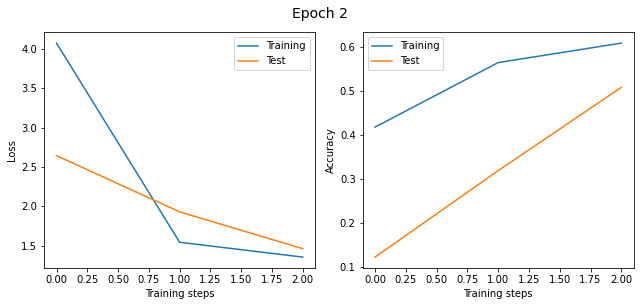

Epoch 3
2020-12-08 15:53:08.099718
Training accuracy: 0.6348665281329923
Test accuracy: 0.5398536392405063
Epoch 4
2020-12-08 15:54:17.472673
Training accuracy: 0.6570891943734015
Test accuracy: 0.35917721518987344
Epoch 5
2020-12-08 15:55:26.487219
Training accuracy: 0.6730059143222507
Test accuracy: 0.556368670886076
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
gaussian_dropout (GaussianDr multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________


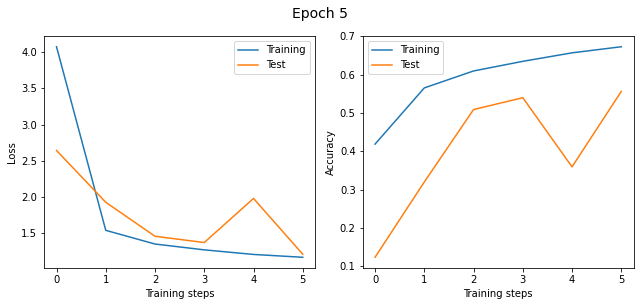

Epoch 6
2020-12-08 15:56:36.026674
Training accuracy: 0.6860334079283887
Test accuracy: 0.4708267405063291
Epoch 7
2020-12-08 15:57:45.511007
Training accuracy: 0.7018622122762149
Test accuracy: 0.6768196202531646
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
gaussian_dropout (GaussianDr multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transition multiple                  15960     
_________________________________________

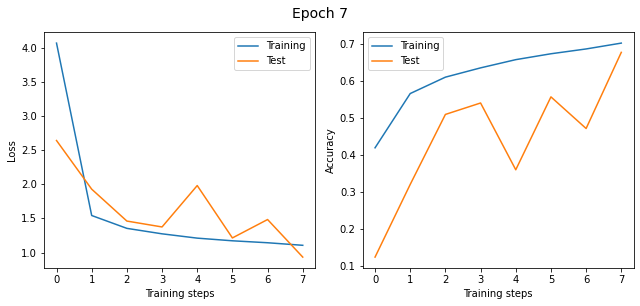

Epoch 8
2020-12-08 15:58:55.440003
Training accuracy: 0.7105378836317136
Test accuracy: 0.6465585443037974
Epoch 9
2020-12-08 16:00:04.703049
Training accuracy: 0.7213794757033247
Test accuracy: 0.6146162974683544
Epoch 10
2020-12-08 16:01:13.716633
Training accuracy: 0.7282368925831203
Test accuracy: 0.6690071202531646
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
gaussian_dropout (GaussianDr multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________

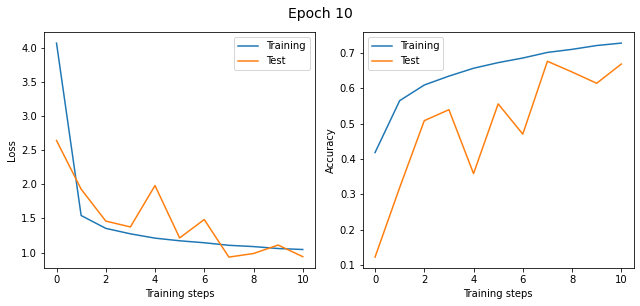

Epoch 11
2020-12-08 16:02:23.189139
Training accuracy: 0.7332720588235294
Test accuracy: 0.5735759493670886
Epoch 12
2020-12-08 16:03:32.013199
Training accuracy: 0.7434502877237851
Test accuracy: 0.6575356012658228
Epoch 13
2020-12-08 16:04:41.070280
Training accuracy: 0.745016783887468
Test accuracy: 0.6196598101265823
Epoch 14
2020-12-08 16:05:49.814948
Training accuracy: 0.7504235933503836
Test accuracy: 0.585245253164557
Epoch 15
2020-12-08 16:06:58.678295
Training accuracy: 0.7556425831202046
Test accuracy: 0.6496242088607594
Epoch 16
2020-12-08 16:08:07.365899
Training accuracy: 0.7601023017902813
Test accuracy: 0.5915743670886076
Epoch 17
2020-12-08 16:09:16.309407
Training accuracy: 0.7618366368286446
Test accuracy: 0.4541139240506329
Epoch 18
2020-12-08 16:10:25.084181
Training accuracy: 0.7650095907928388
Test accuracy: 0.6952136075949367
Epoch 19
2020-12-08 16:11:33.833760
Training accuracy: 0.7638746803069054
Test accuracy: 0.671875
Epoch 20
2020-12-08 16:12:42.756042
Trai

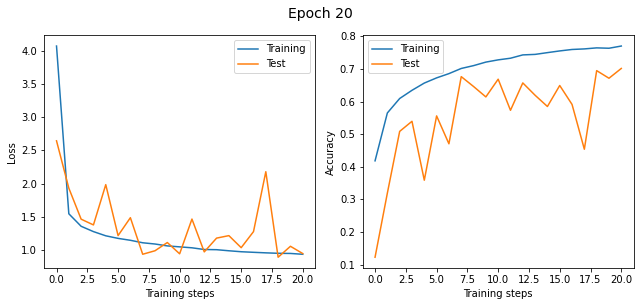

Epoch 21
2020-12-08 16:13:52.033787
Training accuracy: 0.7745364450127877
Test accuracy: 0.5172072784810127
Epoch 22
2020-12-08 16:15:01.154753
Training accuracy: 0.7769781010230179
Test accuracy: 0.6954113924050633
Epoch 23
2020-12-08 16:16:10.100386
Training accuracy: 0.7766584079283887
Test accuracy: 0.5341178797468354
Epoch 24
2020-12-08 16:17:19.186391
Training accuracy: 0.7797354539641943
Test accuracy: 0.6686115506329114
Epoch 25
2020-12-08 16:18:28.132308
Training accuracy: 0.7805067135549872
Test accuracy: 0.6887856012658228
Epoch 26
2020-12-08 16:19:36.856995
Training accuracy: 0.7829723465473145
Test accuracy: 0.7139042721518988
Epoch 27
2020-12-08 16:20:45.706433
Training accuracy: 0.7863011508951407
Test accuracy: 0.41089794303797467
Epoch 28
2020-12-08 16:21:54.532023
Training accuracy: 0.7873481457800511
Test accuracy: 0.6146162974683544
Epoch 29
2020-12-08 16:23:03.561413
Training accuracy: 0.7842631074168799
Test accuracy: 0.6024525316455697
Epoch 30
2020-12-08 16:24:1

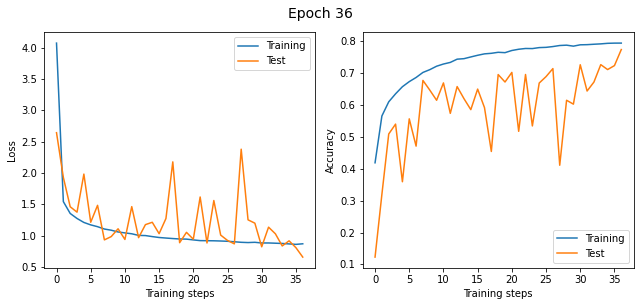

Epoch 37
2020-12-08 16:32:16.420874
Training accuracy: 0.7958639705882353
Test accuracy: 0.7293314873417721
Epoch 38
2020-12-08 16:33:25.425159
Training accuracy: 0.7945052749360614
Test accuracy: 0.6738528481012658
Epoch 39
2020-12-08 16:34:34.638465
Training accuracy: 0.7968789961636829
Test accuracy: 0.6854232594936709
Epoch 40
2020-12-08 16:35:44.055004
Training accuracy: 0.7971227621483377
Test accuracy: 0.6790941455696202
Epoch 41
2020-12-08 16:36:53.274791
Training accuracy: 0.7985653772378516
Test accuracy: 0.6316257911392406
Epoch 42
2020-12-08 16:38:02.471539
Training accuracy: 0.797822090792839
Test accuracy: 0.7276503164556962
Epoch 43
2020-12-08 16:39:11.889418
Training accuracy: 0.8005394820971867
Test accuracy: 0.6099683544303798
Epoch 44
2020-12-08 16:40:21.196201
Training accuracy: 0.7992287404092072
Test accuracy: 0.6889833860759493
Epoch 45
2020-12-08 16:41:30.608437
Training accuracy: 0.8011069373401535
Test accuracy: 0.7160799050632911
Epoch 46
2020-12-08 16:42:40.

In [9]:
# Description: This part creates objects of a ResNet and DenseNet and executes the training and testing of these models in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

num_dense_blocks = 3
num_conv_blocks = 3 
growth_rate = 40
model = DenseNet(num_dense_blocks, num_conv_blocks, growth_rate)   

n_epochs = 50
learning_rate = 0.001
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5                                    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))
    ts_now = dt.datetime.now()
    print(ts_now)

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print("Training accuracy: " + str(training_accuracy))
    print("Test accuracy: " + str(test_accuracy))

    # Visualization during training to check how the CNN is doing. In 5% steps of the test accuracy starting up from 50% test accuracy.
    if test_accuracy >= dynamic_threshold_train_visio: 
      model.summary()  #!!!find a different place for this!!!

      fig, ax = plt.subplots(1,2, figsize=(9, 4))

      fig.suptitle(('Epoch ' + str(epoch)), fontsize=14, y=1.05)
      line1, = ax[0].plot(training_losses)
      line2, = ax[0].plot(test_losses)
      ax[0].set_xlabel("Training steps")
      ax[0].set_ylabel("Loss")
      ax[0].legend((line1, line2),("Training", "Test"))

      line1, = ax[1].plot(training_accuracies)
      line2, = ax[1].plot(test_accuracies)
      ax[1].set_xlabel("Training steps")
      ax[1].set_ylabel("Accuracy")
      ax[1].legend((line1, line2),("Training", "Test"))

      fig.tight_layout()
      plt.draw()
      plt.show()

      # Increases the test accuracy threshold by 5%.  
      dynamic_threshold_train_visio += 0.05

# **Visualization**

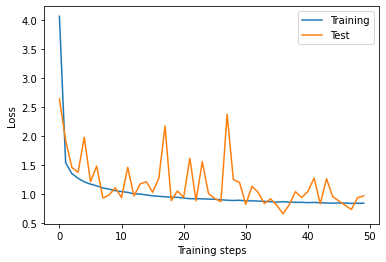

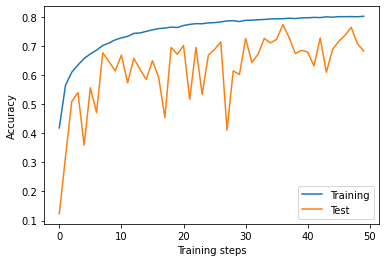

In [10]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()